### Exploring HDBSCAN

With this notebook we explore the possibilities of HDBSCAN, the extended and allegedly
better performing brother of DBSCAN.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import s2spy.time
import s2spy.rgdr
from s2spy import RGDR
import hdbscan
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd

First we will load in some example data, and resample them using `s2spy`'s `Calendar`.

In [2]:
file_path = '../tests/test_rgdr/test_data'
field = xr.open_dataset(f'{file_path}/sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc')
target = xr.open_dataset(f'{file_path}/tf5_nc5_dendo_80d77.nc')

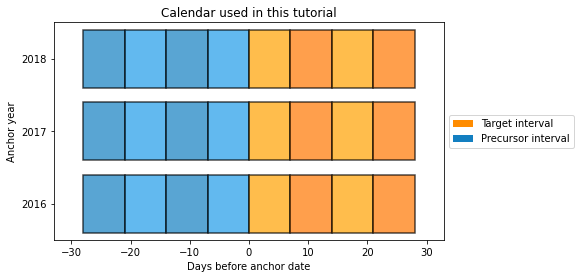

In [3]:
cal = s2spy.time.Calendar(anchor="08-01")
cal.add_intervals("target", length="1W", n=4)
cal.add_intervals("precursor", length="1W", n=4)

cal = cal.map_to_data(field)
cal.visualize(n_years=3, relative_dates=True)
_ = plt.title("Calendar used in this tutorial")

In [4]:
field_resampled: xr.Dataset = s2spy.time.resample(cal, field)
target_resampled: xr.Dataset = s2spy.time.resample(cal, target)

Text(0.5, 1.0, 'DBSCAN')

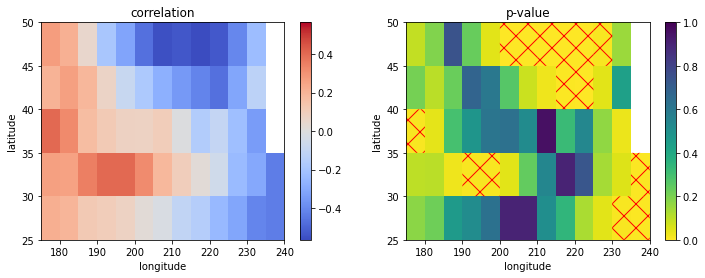

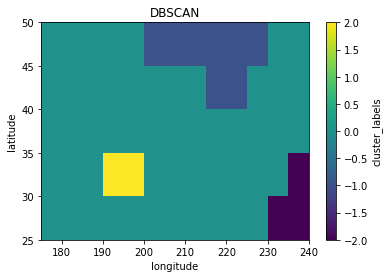

In [5]:
target_timeseries = target_resampled.sel(cluster=3)["ts"]
precursor_field = field_resampled["sst"]

target_intervals = 1
lag = 4
alpha = 0.01
eps_km = 600
min_area_km2 = 600**2

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
rgdr = RGDR(target_intervals, lag, eps_km=eps_km, alpha=alpha, min_area_km2=min_area_km2)
_ = rgdr.preview_correlation(precursor_field, target_timeseries, ax1=ax1, ax2=ax2)

fig, ax = plt.subplots(figsize=(6, 4))
RGDR(
    target_intervals, lag, eps_km=eps_km, alpha=alpha, min_area_km2=min_area_km2
    ).preview_clusters(precursor_field, target_timeseries, ax=ax, vmin=-2, vmax=2)
ax.set_title('DBSCAN')

### Explore hdbscan
Let's try to reproduce this result with HDBSCAN.

In [6]:
rgdr = RGDR(target_intervals, lag, eps_km=eps_km, alpha=alpha, min_area_km2=min_area_km2)
corr, p_vals = rgdr.get_correlation(precursor_field, target_timeseries)
data = precursor_field.to_dataset()
data["corr"], data["p_val"] = corr, p_vals  # Will require less tracking of indices
data = data.stack(coord=["latitude", "longitude"])
coords = np.asarray(data["coord"].values.tolist())
coords = np.radians(coords)

In [7]:
labels = np.zeros(len(coords), dtype=int)
clusterers = []
for sign, sign_mask in zip([1, -1], [data["corr"] >= 0, data["corr"] < 0]):
    mask = np.logical_and(data["p_val"] < alpha, sign_mask)
    if np.sum(mask) > 0:  # Check if the mask contains any points to cluster
        clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, metric='haversine')
        clusterers.append(clusterer)
        db = clusterer.fit(coords[mask]) #noisy samples are -1
        labels[mask] = sign * (db.labels_ + 1)

plot DBSCAN (left) and HDBSCAN (right)

Text(0.5, 1.0, 'HDBSCAN')

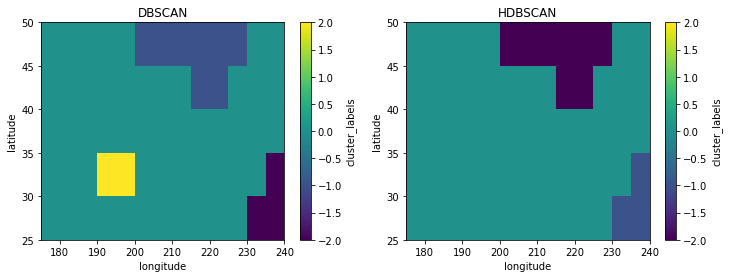

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

#HDBSCAN
precursor = precursor_field.stack(coord=["latitude", "longitude"])
precursor["cluster_labels"] = ("coord", labels)
precursor["cluster_labels"] = precursor["cluster_labels"].astype("int16")
precursor = precursor.unstack(("coord"))
precursor["cluster_labels"].plot(cmap="viridis", ax=ax2, vmin=-2, vmax=2)
#DBSCAN
RGDR(
    target_intervals, lag, eps_km=eps_km, alpha=alpha, min_area_km2=min_area_km2
    ).preview_clusters(precursor_field, target_timeseries, ax=ax1, vmin=-2, vmax=2)

ax1.set_title('DBSCAN')
ax2.set_title('HDBSCAN')


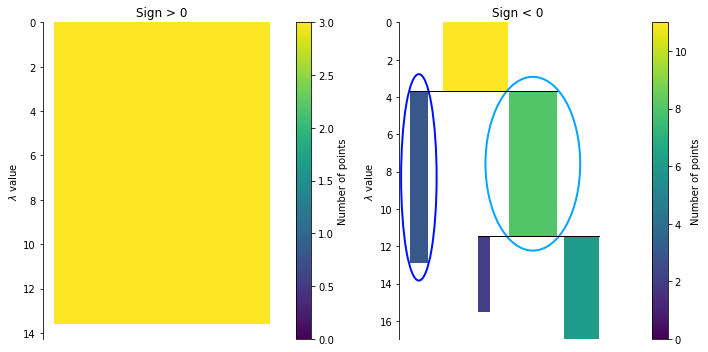

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
clusterers[0].condensed_tree_.plot(select_clusters=True,
                               selection_palette=plt.cm.jet(np.linspace(0, 1, 8))[1:-1], cmap='viridis', colorbar=True, axis=ax1)
clusterers[1].condensed_tree_.plot(select_clusters=True,
                               selection_palette=plt.cm.jet(np.linspace(0, 1, 8))[1:-1], cmap='viridis', colorbar=True, axis=ax2)
ax1.set_title('Sign > 0')
ax2.set_title('Sign < 0')
fig.tight_layout()

Not possible to get the same results with this test data set since HDBSCAN cannot estimate the pdf with only 3 points for the positive correlation.
Proceed with bigger dataset.

#### proceed with bigger dataset

First we will load in some data, and resample them using `s2spy`'s `Calendar`.

In [10]:
data_path = '../data'
testdata_path = '../tests/test_rgdr/test_data'
field = xr.open_dataset(f'{data_path}/preprocessed/era5_sst_1959-2021_1jan_31dec_daily_2.0deg.nc')
target = xr.open_dataset(f'{testdata_path}/tf5_nc5_dendo_80d77.nc')

reduce the size of the field in extent and time a bit

In [11]:
field = field.sel({'time':target['time'].values})
field = field.sel({'longitude':slice(180.0,260.0), 'latitude':slice(-30.0,80.0)})

Create calendar, map it to dataset and visualize it.

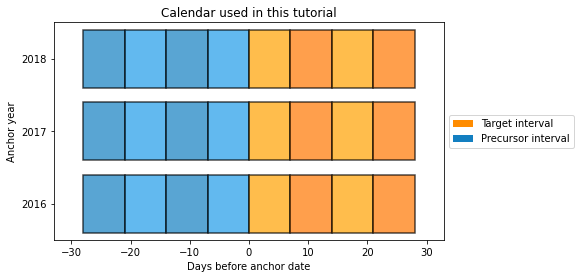

In [12]:
cal = s2spy.time.Calendar(anchor="08-01")
cal.add_intervals("target", length="1W", n=4)
cal.add_intervals("precursor", length="1W", n=4)

cal = cal.map_to_data(field)
cal.visualize(n_years=3, relative_dates=True)
_ = plt.title("Calendar used in this tutorial")

Resample data with calendar.

In [13]:
field_resampled: xr.Dataset = s2spy.time.resample(cal, field)
target_resampled: xr.Dataset = s2spy.time.resample(cal, target)

Text(0.5, 1.0, 'DBSCAN')

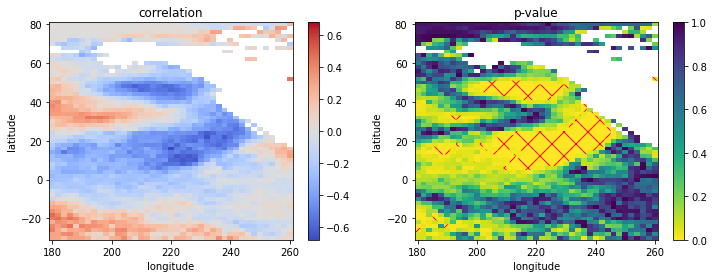

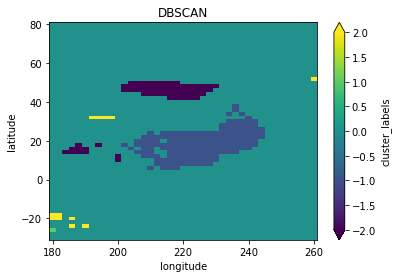

In [14]:
target_timeseries = target_resampled.sel(cluster=3)["ts"]
precursor_field = field_resampled["sst"]

target_intervals = 1
lag = 4
alpha = 0.01
eps_km = 600
min_area_km2 = 0**2

rgdr = RGDR(
    target_intervals=target_intervals,
    lag=lag,
    eps_km=eps_km,
    alpha=alpha,
    min_area_km2=min_area_km2
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
_ = rgdr.preview_correlation(precursor_field, target_timeseries, ax1=ax1, ax2=ax2)

fig, ax = plt.subplots(figsize=(6, 4))
RGDR(
    target_intervals, lag, eps_km=eps_km, alpha=alpha, min_area_km2=min_area_km2
    ).preview_clusters(precursor_field, target_timeseries, ax=ax, vmin=-2, vmax=2)
ax.set_title('DBSCAN')

try HDBSCAN

In [15]:
def hdbscanner(precursor, target, min_cluster_size = 5, min_samples = 1, metric='haversine', alpha=0.01):
    corr, p_vals = rgdr.get_correlation(precursor, target)
    data = precursor_field.to_dataset()
    data["corr"], data["p_val"] = corr, p_vals  # Will require less tracking of indices
    data = data.stack(coord=["latitude", "longitude"])
    coords = np.asarray(data["coord"].values.tolist())
    coords = np.radians(coords)

    labels = np.zeros(len(coords), dtype=int)
    clusterers = []
    for sign, sign_mask in zip([1, -1], [data["corr"] >= 0, data["corr"] < 0]):
        mask = np.logical_and(data["p_val"] < alpha, sign_mask)
        if np.sum(mask) > 0:  # Check if the mask contains any points to cluster
            clusterer = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, min_samples=min_samples, metric='haversine')
            clusterers.append(clusterer)
            db = clusterer.fit(coords[mask]) #noisy samples are -1
            labels[mask] = sign * (db.labels_ + 1)
    
    #plot clusters
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(14, 4))
    precursor = precursor_field.stack(coord=["latitude", "longitude"])
    precursor["cluster_labels"] = ("coord", labels)
    precursor["cluster_labels"] = precursor["cluster_labels"].astype("int16")
    precursor = precursor.unstack(("coord"))
    precursor["cluster_labels"].plot(cmap="viridis", ax=ax1, vmin=-2, vmax=2)
    ax1.set_title(f'HDBSCAN_min-cl={min_cluster_size}_min_samples={min_samples}')
    #plot condensed tree
    clusterers[0].condensed_tree_.plot(select_clusters=True,
                                selection_palette=plt.cm.jet(np.linspace(0, 1, 8))[1:-1], cmap='viridis', colorbar=True, axis=ax2)
    clusterers[1].condensed_tree_.plot(select_clusters=True,
                                selection_palette=plt.cm.jet(np.linspace(0, 1, 8))[1:-1], cmap='viridis', colorbar=True, axis=ax3)
    ax2.set_title('Sign > 0')
    ax3.set_title('Sign < 0')
    fig.tight_layout()

Let's try some configurations with min_cluster_size ranging from 2 (minimum) to 8:

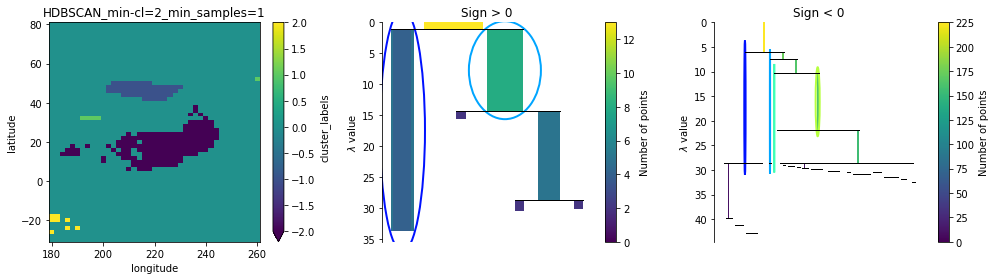

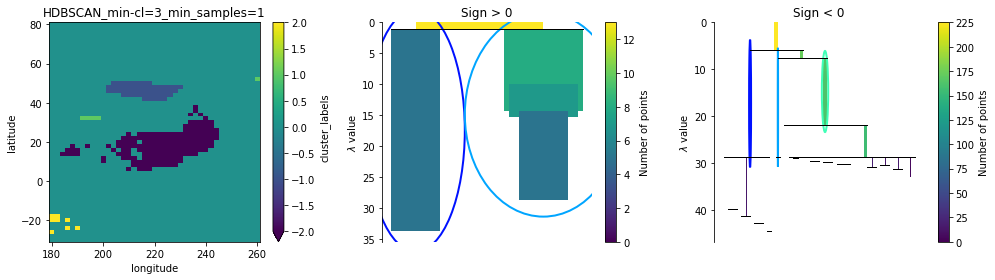

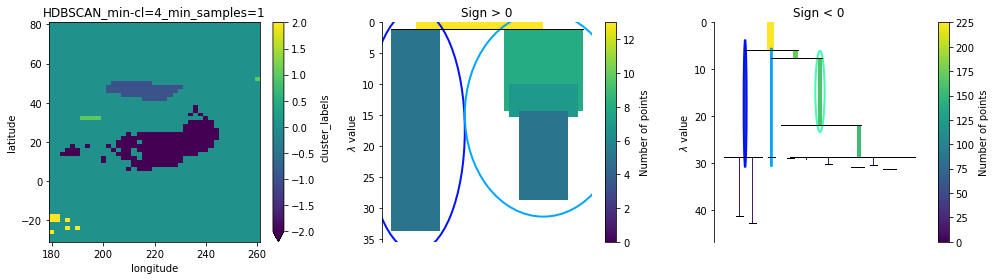

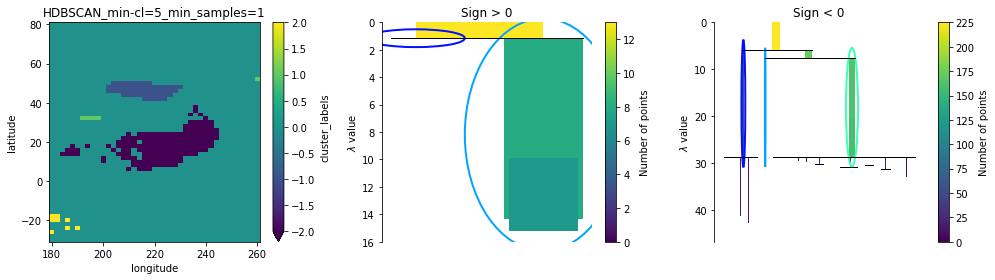

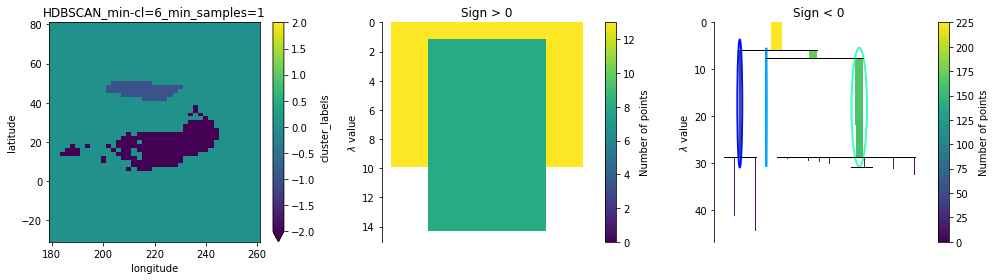

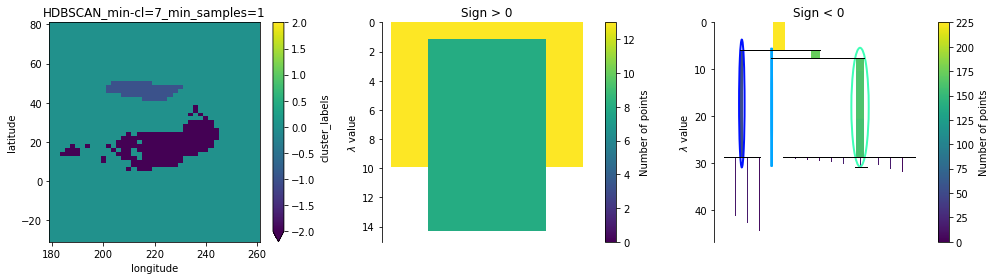

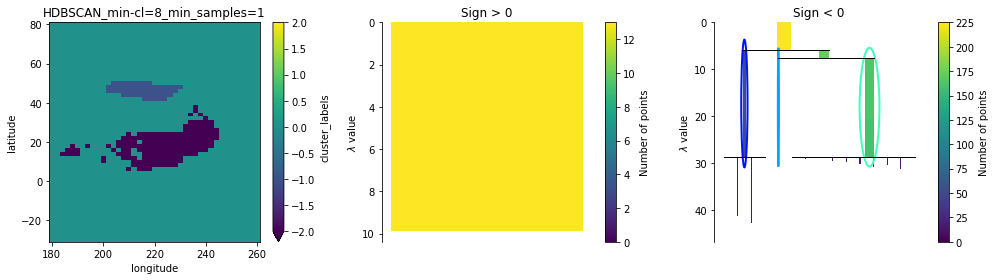

In [16]:
for i in range(2,9):
    hdbscanner(precursor_field, target_timeseries, min_cluster_size=i)

Let's try some configurations with min_samples ranging from 1 to 5: (while min_cluster_size is at it's default setting 5)

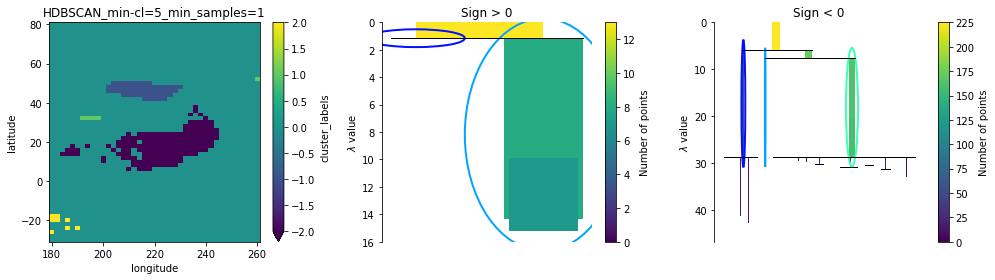

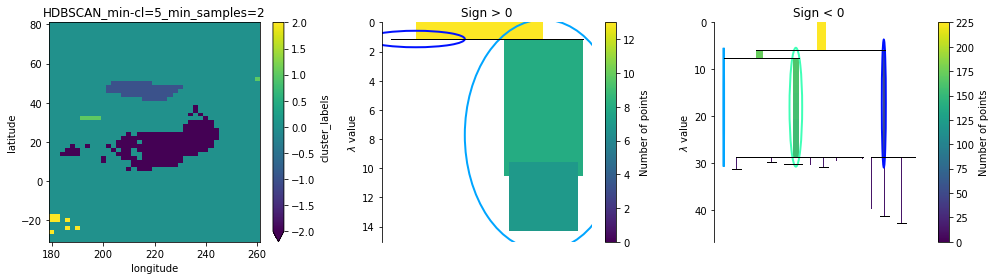

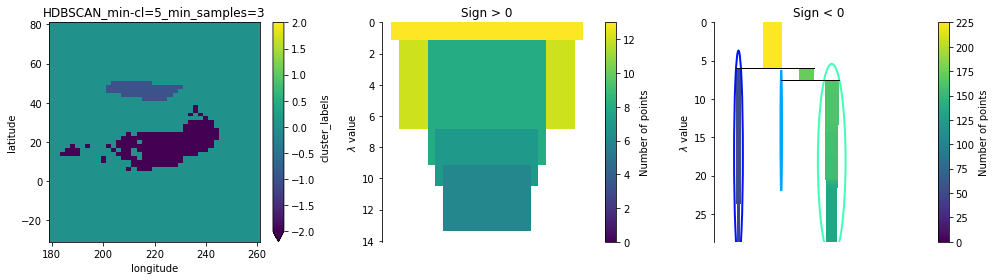

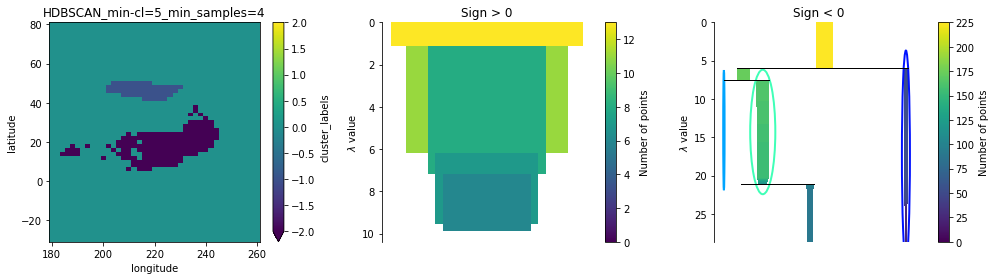

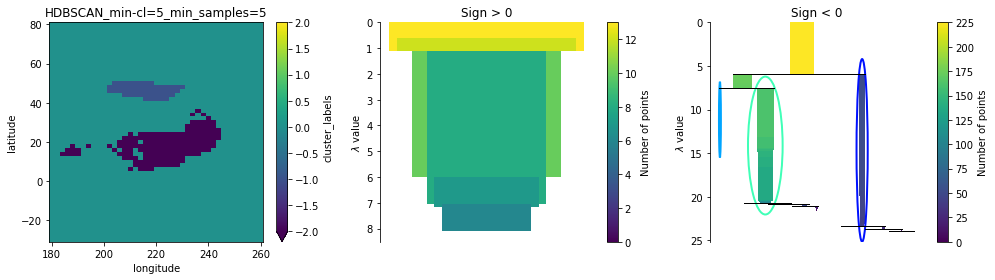

In [17]:
for i in range(1,6):
    hdbscanner(precursor_field, target_timeseries, min_samples=i)

### Test speed
Let's test the speed of DBSCAN vs HDBSCAN on the last dataset

In [18]:
import time

corr, p_vals = rgdr.get_correlation(precursor_field, target_timeseries)
data = precursor_field.to_dataset()
data["corr"], data["p_val"] = corr, p_vals  # Will require less tracking of indices
data = data.stack(coord=["latitude", "longitude"])
coords = np.asarray(data["coord"].values.tolist())
coords = np.radians(coords)

#DBSCAN
def DBSCANner(min_samples=1, eps_km = 600, alpha=0.01):
        labels = np.zeros(len(coords), dtype=int)
        clusterers = []
        for sign, sign_mask in zip([1, -1], [data["corr"] >= 0, data["corr"] < 0]):
                mask = np.logical_and(data["p_val"] < alpha, sign_mask)
                if np.sum(mask) > 0:  # Check if the mask contains any points to cluster
                        clusterer = DBSCAN(
                                eps=eps_km / 6371,
                                min_samples=min_samples,
                                algorithm="auto",
                                metric="haversine")
                        clusterers.append(clusterer)
                        db = clusterer.fit(coords[mask]) #noisy samples are -1
                        labels[mask] = sign * (db.labels_ + 1)
        return labels

#HDBSCAN
def HDBSCANner(min_samples=1, min_cluster_size=5, alpha=0.01):
        labels = np.zeros(len(coords), dtype=int)
        clusterers = []
        for sign, sign_mask in zip([1, -1], [data["corr"] >= 0, data["corr"] < 0]):
                mask = np.logical_and(data["p_val"] < alpha, sign_mask)
                if np.sum(mask) > 0:  # Check if the mask contains any points to cluster
                        clusterer = hdbscan.HDBSCAN(
                                min_samples=min_samples,
                                min_cluster_size=min_cluster_size,
                                metric='haversine'
                                )
                        clusterers.append(clusterer)
                        db = clusterer.fit(coords[mask]) #noisy samples are -1
                        labels[mask] = sign * (db.labels_ + 1)

        return labels


In [19]:
#pandas dataframe
def plot_runtimes(runtimes_DBSCAN, runtimes_HDBSCAN, index, n_runs=1):
    df_DBSCAN = pd.DataFrame(runtimes_DBSCAN, index=index)
    df_HDBSCAN = pd.DataFrame(runtimes_HDBSCAN, index=index)
    d = {'DBSCAN': df_DBSCAN, 'HDBSCAN': df_HDBSCAN}
    df = pd.concat(d.values(), axis=1, keys=d.keys())
    df = df.transpose()
    df.groupby(level=[0]).sum().transpose().plot(kind='bar', ylabel='s', xlabel='', title=f'total time {n_runs} runs')
    #df.groupby(level=[0]).mean().transpose().plot(kind='bar', ylabel='s', xlabel='', title=f'mean time {n_runs} runs')

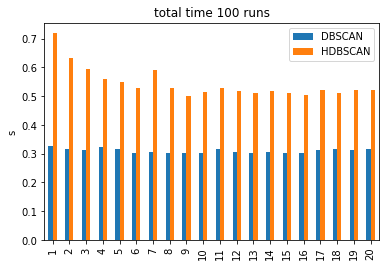

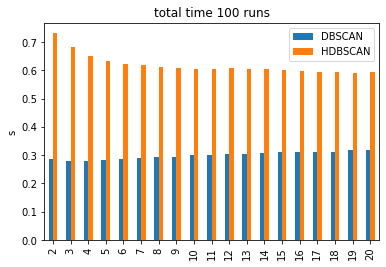

In [20]:
import time
runs = 100

#min_samples
min_samples = 20
DBSCAN_times = []
for i in np.arange(1, min_samples+1):
    start_time = time.time()
    for j in np.arange(1, runs+1):
        _ = DBSCANner(min_samples=i)
    end_time = time.time()
    exec_time = end_time-start_time
    DBSCAN_times.append(exec_time)

HDBSCAN_times = []
for i in np.arange(1, min_samples+1):
    start_time = time.time()
    for j in np.arange(1, runs+1):
        _ = HDBSCANner(min_samples=i)
    end_time = time.time()
    exec_time = end_time-start_time
    HDBSCAN_times.append(exec_time)

plot_runtimes(runtimes_DBSCAN=DBSCAN_times, runtimes_HDBSCAN=HDBSCAN_times, index=np.arange(1, min_samples+1), n_runs=runs)

#min_cluster_size and eps
min_cluster_size = 20
eps_km = 1000

DBSCAN_times = []
for i in np.arange(100, eps_km+1, 50):
    start_time = time.time()
    for j in np.arange(1, runs+1):
        _ = DBSCANner(eps_km=i)
    end_time = time.time()
    exec_time = end_time-start_time
    DBSCAN_times.append(exec_time)

HDBSCAN_times = []
for i in np.arange(2, min_cluster_size+1):
    start_time = time.time()
    for j in np.arange(1, runs+1):
        _ = HDBSCANner(min_cluster_size=i)
    end_time = time.time()
    exec_time = end_time-start_time
    HDBSCAN_times.append(exec_time)

plot_runtimes(runtimes_DBSCAN=DBSCAN_times, runtimes_HDBSCAN=HDBSCAN_times, index=np.arange(2, min_cluster_size+1), n_runs=runs)